In [1]:
# torch and torchvision imports
import torch
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from ResnetModel import *
from transformer import *
writer = SummaryWriter()
# from google.colab import drive
# drive.mount('/gdrive')
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


2023-12-09 20:10:05.904219: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-09 20:10:06.083361: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 20:10:06.083436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 20:10:06.108089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 20:10:06.165560: I tensorflow/core/platform/cpu_feature_guar

Device: cuda


### Loading and Preparing Data

In [4]:
import os

In [7]:
os.listdir('../')

['ecg_ptbxl_benchmarking',
 'runs',
 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1',
 '99_Ref',
 '.git',
 'src',
 '.gitignore']

In [12]:
path = '../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/Datasets/'
X_train_form = np.load(path+'FormTrain.npz')['x']
X_train_rhythm = np.load(path+'RhythmTrain.npz')['x']
X_train_CD = np.load(path+'CDTrain.npz')['x']
X_train_HYP = np.load(path+'HYPTrain.npz')['x']
X_train_MI = np.load(path+'MITrain.npz')['x']
X_train_STTC = np.load(path+'STTCTrain.npz')['x']
Y_train_form = np.load(path+'FormTrain.npz')['y']
Y_train_rhythm = np.load(path+'RhythmTrain.npz')['y']
Y_train_CD = np.load(path+'CDTrain.npz')['y']
Y_train_HYP = np.load(path+'HYPTrain.npz')['y']
Y_train_MI = np.load(path+'MITrain.npz')['y']
Y_train_STTC = np.load(path+'STTCTrain.npz')['y']
X_val_form = np.load(path+'FormVal.npz')['x']
X_val_rhythm = np.load(path+'RhythmVal.npz')['x']
X_val_CD = np.load(path+'CDVal.npz')['x']
X_val_HYP = np.load(path+'HYPVal.npz')['x']
X_val_MI = np.load(path+'MIVal.npz')['x']
X_val_STTC = np.load(path+'STTCVal.npz')['x']
Y_val_form = np.load(path+'FormVal.npz')['y']
Y_val_rhythm = np.load(path+'RhythmVal.npz')['y']
Y_val_CD = np.load(path+'CDVal.npz')['y']
Y_val_HYP = np.load(path+'HYPVal.npz')['y']
Y_val_MI = np.load(path+'MIVal.npz')['y']
Y_val_STTC = np.load(path+'STTCVal.npz')['y']


In [13]:
form_train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train_form), torch.from_numpy(Y_train_form))
rhythm_train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train_rhythm), torch.from_numpy(Y_train_rhythm))
CD_train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train_CD), torch.from_numpy(Y_train_CD))
HYP_train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train_HYP), torch.from_numpy(Y_train_HYP))
MI_train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train_MI), torch.from_numpy(Y_train_MI))
STTC_train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train_STTC), torch.from_numpy(Y_train_STTC))
form_val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val_form), torch.from_numpy(Y_val_form))
rhythm_val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val_rhythm), torch.from_numpy(Y_val_rhythm))
CD_val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val_CD), torch.from_numpy(Y_val_CD))
HYP_val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val_HYP), torch.from_numpy(Y_val_HYP))
MI_val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val_MI), torch.from_numpy(Y_val_MI))
STTC_val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val_STTC), torch.from_numpy(Y_val_STTC))

del X_train_form, X_train_rhythm, X_train_CD, X_train_HYP, X_train_MI, X_train_STTC, Y_train_form, Y_train_rhythm, Y_train_CD, Y_train_HYP, Y_train_MI, Y_train_STTC, X_val_form, X_val_rhythm, X_val_CD, X_val_HYP, X_val_MI, X_val_STTC, Y_val_form, Y_val_rhythm, Y_val_CD, Y_val_HYP, Y_val_MI, Y_val_STTC

In [15]:
with open(path+'category.pickle', 'rb') as f:
    category = pickle.load(f)
num_classes = [len(category[key]) for key in category.keys()]
models = [key for key in category.keys()]
print(num_classes)
print(models)

[19, 12, 13, 14, 5, 11]
['Form', 'Rhythm', 'STTC', 'MI', 'HYP', 'CD']


### Creating the Resnet Model

In [16]:
form_model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes[0]).to(device)
rhythm_model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes[1]).to(device)
STTC_model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes[2]).to(device)
MI_model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes[3]).to(device)
HYP_model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes[4]).to(device)
CD_model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes[5]).to(device)

In [17]:
form_train_loader = torch.utils.data.DataLoader(form_train_dataset, batch_size=10, shuffle=True)
rhythm_train_loader = torch.utils.data.DataLoader(rhythm_train_dataset, batch_size=10, shuffle=True)
STCC_train_loader = torch.utils.data.DataLoader(STTC_train_dataset, batch_size=10, shuffle=True)
MI_train_loader = torch.utils.data.DataLoader(MI_train_dataset, batch_size=10, shuffle=True)
HYP_train_loader = torch.utils.data.DataLoader(HYP_train_dataset, batch_size=10, shuffle=True)
CD_train_loader = torch.utils.data.DataLoader(CD_train_dataset, batch_size=10, shuffle=True)
form_val_loader = torch.utils.data.DataLoader(form_val_dataset, batch_size=10, shuffle=True)
rhythm_val_loader = torch.utils.data.DataLoader(rhythm_val_dataset, batch_size=10, shuffle=True)
STCC_val_loader = torch.utils.data.DataLoader(STTC_val_dataset, batch_size=10, shuffle=True)
MI_val_loader = torch.utils.data.DataLoader(MI_val_dataset, batch_size=10, shuffle=True)
HYP_val_loader = torch.utils.data.DataLoader(HYP_val_dataset, batch_size=10, shuffle=True)
CD_val_loader = torch.utils.data.DataLoader(CD_val_dataset, batch_size=10, shuffle=True)


In [ ]:
form_metric = MultilabelAUROC(num_classes=num_classes[0])
rhythm_metric = MultilabelAUROC(num_classes=num_classes[1])
STTC_metric = MultilabelAUROC(num_classes=num_classes[2])
MI_metric = MultilabelAUROC(num_classes=num_classes[3])
HYP_metric = MultilabelAUROC(num_classes=num_classes[4])
CD_metric = MultilabelAUROC(num_classes=num_classes[5])

form_criterion = nn.BCELoss()
rhythm_criterion = nn.BCELoss()
STTC_criterion = nn.BCELoss()
MI_criterion = nn.BCELoss()
HYP_criterion = nn.BCELoss()
CD_criterion = nn.BCELoss()

form_optimizer = torch.optim.Adam(form_model.parameters(), lr=0.0001, weight_decay=1e-4)
rhythm_optimizer = torch.optim.Adam(rhythm_model.parameters(), lr=0.0001, weight_decay=1e-4)
STTC_optimizer = torch.optim.Adam(STTC_model.parameters(), lr=0.0001, weight_decay=1e-4)
MI_optimizer = torch.optim.Adam(MI_model.parameters(), lr=0.0001, weight_decay=1e-4)
HYP_optimizer = torch.optim.Adam(HYP_model.parameters(), lr=0.0001, weight_decay=1e-4)
CD_optimizer = torch.optim.Adam(CD_model.parameters(), lr=0.0001, weight_decay=1e-4)

models = [form_model, rhythm_model, STTC_model, MI_model, HYP_model, CD_model]
optimizers = [form_optimizer, rhythm_optimizer, STTC_optimizer, MI_optimizer, HYP_optimizer, CD_optimizer]
criterions = [form_criterion, rhythm_criterion, STTC_criterion, MI_criterion, HYP_criterion, CD_criterion]
train_loaders = [form_train_loader, rhythm_train_loader, STCC_train_loader, MI_train_loader, HYP_train_loader, CD_train_loader]
val_loaders = [form_val_loader, rhythm_val_loader, STCC_val_loader, MI_val_loader, HYP_val_loader, CD_val_loader]

lr_max = 0.00035
lr = lr_max
epochs = 10

ts = np.zeros(len(models), dtype=np.int32)
steps_per_epoch = [len(loader) for loader in train_loaders]
T_maxs = [steps_per_epoch[i]*epochs for i in range(len(models))]
T_0s = [T_maxs[i]//5 for i in range(len(models))]
for optimizer in optimizers:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_max

for i in range(len(models)):
    for t in range(T_maxs[i]):
        if t < T_0s[i]:
            lr = lr_max*(t/T_0s[i])
        else:
            lr = lr_max*(1+np.cos((t-T_0s[i])/(T_maxs[i]-T_0s[i])*np.pi))/2
            


In [7]:
lr_max = 0.0003/10
lr = lr_max
epochs = 100
criterion = nn.BCELoss()
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=3).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

for g in optimizer.param_groups:
    g['lr'] = lr

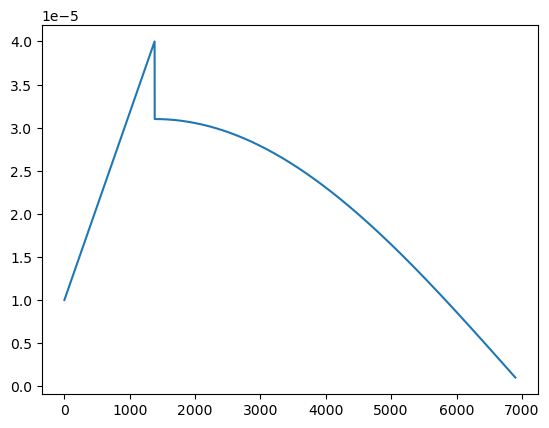

In [8]:
lrs = []
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
for t in range(T_max):
    if t <= T_0:
        lr = 10**(-5) + (t/T_0)*lr_max  
    else: 
        lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6)
    lrs.append(lr)

fig = plt.figure()
plt.plot(lrs)
plt.show()


In [9]:
lr =lr_max

In [10]:
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
learning_rates = []
train_losses = []

for epoch in range(epochs):
    for i, (signal, labels) in enumerate(train_loader):
        idx = np.random.randint(0, 1000-200)
        signal_sample = (signal[:, :, idx:idx+200]).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(signal_sample)
        loss = criterion(outputs, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        if t <= T_0:
            lr = 10**(-4) + (t/T_0)*lr_max  
        else: 
            lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6) 

        for g in optimizer.param_groups:
            g['lr'] = lr 
        learning_rates.append(lr)
        train_losses.append(loss.item())
        optimizer.step()
        t+=1
        
        train_AUC = ml_auroc(outputs, labels.int())
        writer.add_scalar("Train_Loss", loss, t)
        writer.add_scalar("Learning rate", lr, t)
        writer.add_scalar("Batch Train AUC", train_AUC, t)

        if i%(len(train_loader)//10) == 0:
            print(f"Step: {i+1}/{len(train_loader)}  |  Train loss: {loss.item():.4f}  |  Train AUC: {train_AUC:.4f}")
           

    # model.eval()
    test_auc = 0
    with torch.no_grad():
        for i, (signal, labels) in enumerate(test_loader):
            idx = np.random.randint(0, 1000-200)
            signal = (signal[:, :, idx:idx+200]).to(device)
            labels = labels.to(device)
            outputs = model(signal)
            test_auc += ml_auroc(outputs, labels.int())
        test_auc /= len(test_loader)
    writer.add_scalar("Test AUC", test_auc, epoch)

Step: 1/69  |  Train loss: 0.7543  |  Train AUC: 0.5023
Step: 7/69  |  Train loss: 0.3516  |  Train AUC: 0.5274
Step: 13/69  |  Train loss: 0.3085  |  Train AUC: 0.5899
Step: 19/69  |  Train loss: 0.2878  |  Train AUC: 0.5991
Step: 25/69  |  Train loss: 0.2150  |  Train AUC: 0.7439
Step: 31/69  |  Train loss: 0.2168  |  Train AUC: 0.7063
Step: 37/69  |  Train loss: 0.2510  |  Train AUC: 0.6771
Step: 43/69  |  Train loss: 0.2096  |  Train AUC: 0.6751
Step: 49/69  |  Train loss: 0.2756  |  Train AUC: 0.6486
Step: 55/69  |  Train loss: 0.2524  |  Train AUC: 0.6900
Step: 61/69  |  Train loss: 0.2423  |  Train AUC: 0.7185
Step: 67/69  |  Train loss: 0.2343  |  Train AUC: 0.6433


/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Step: 1/69  |  Train loss: 0.2540  |  Train AUC: 0.7334
Step: 7/69  |  Train loss: 0.3053  |  Train AUC: 0.6319
Step: 13/69  |  Train loss: 0.2293  |  Train AUC: 0.6893
Step: 19/69  |  Train loss: 0.2149  |  Train AUC: 0.5353
Step: 25/69  |  Train loss: 0.2625  |  Train AUC: 0.7101
Step: 31/69  |  Train loss: 0.2167  |  Train AUC: 0.7022
Step: 37/69  |  Train loss: 0.1961  |  Train AUC: 0.6936
Step: 43/69  |  Train loss: 0.2420  |  Train AUC: 0.6387
Step: 49/69  |  Train loss: 0.2648  |  Train AUC: 0.7213
Step: 55/69  |  Train loss: 0.2320  |  Train AUC: 0.5952
Step: 61/69  |  Train loss: 0.2134  |  Train AUC: 0.3889
Step: 67/69  |  Train loss: 0.2831  |  Train AUC: 0.6553
Step: 1/69  |  Train loss: 0.2173  |  Train AUC: 0.6828
Step: 7/69  |  Train loss: 0.2900  |  Train AUC: 0.6507
Step: 13/69  |  Train loss: 0.2273  |  Train AUC: 0.6411
Step: 19/69  |  Train loss: 0.2608  |  Train AUC: 0.6455
Step: 25/69  |  Train loss: 0.2671  |  Train AUC: 0.6945
Step: 31/69  |  Train loss: 0.2135 

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Step: 1/69  |  Train loss: 0.2058  |  Train AUC: 0.8417
Step: 7/69  |  Train loss: 0.2143  |  Train AUC: 0.8304
Step: 13/69  |  Train loss: 0.2099  |  Train AUC: 0.8297
Step: 19/69  |  Train loss: 0.2337  |  Train AUC: 0.8463
Step: 25/69  |  Train loss: 0.1877  |  Train AUC: 0.8489
Step: 31/69  |  Train loss: 0.2424  |  Train AUC: 0.8178
Step: 37/69  |  Train loss: 0.2575  |  Train AUC: 0.8011
Step: 43/69  |  Train loss: 0.2320  |  Train AUC: 0.7771
Step: 49/69  |  Train loss: 0.2232  |  Train AUC: 0.7662
Step: 55/69  |  Train loss: 0.2411  |  Train AUC: 0.7807
Step: 61/69  |  Train loss: 0.2048  |  Train AUC: 0.8508
Step: 67/69  |  Train loss: 0.2257  |  Train AUC: 0.7595
Step: 1/69  |  Train loss: 0.1605  |  Train AUC: 0.8515
Step: 7/69  |  Train loss: 0.1954  |  Train AUC: 0.8464
Step: 13/69  |  Train loss: 0.2187  |  Train AUC: 0.7753
Step: 19/69  |  Train loss: 0.2192  |  Train AUC: 0.7968
Step: 25/69  |  Train loss: 0.2022  |  Train AUC: 0.8622
Step: 31/69  |  Train loss: 0.1828 

In [ ]:
signal.shape

In [ ]:
with open('superclassresnetmodel.pickle', 'wb') as f:
    pickle.dump(model, f)

In [5]:
import pickle, matplotlib.pyplot as plt, torch
with open('./modelres/SuperClasslosses.pickle', 'rb') as f:
    train_losses = pickle.load(f)

In [6]:
len(train_losses)

3

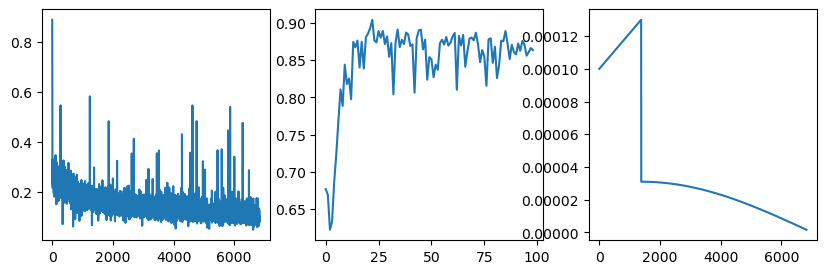

In [7]:
fig,axes = plt.subplots(1,3, figsize = (10,3))
axes[0].plot(train_losses[0])
axes[1].plot(torch.tensor(train_losses[1]))
axes[2].plot(train_losses[2])
plt.show()


In [12]:
torch.tensor(train_losses[0][-2000:]).mean()

tensor(0.1128)

In [11]:
import torch
torch.tensor(train_losses[1]).device

device(type='cpu')

In [12]:
train_losses[2]

[0.0001,
 0.00010002173913043479,
 0.00010004347826086956,
 0.00010006521739130435,
 0.00010008695652173914,
 0.00010010869565217392,
 0.0001001304347826087,
 0.00010015217391304348,
 0.00010017391304347827,
 0.00010019565217391304,
 0.00010021739130434783,
 0.00010023913043478262,
 0.00010026086956521739,
 0.00010028260869565218,
 0.00010030434782608696,
 0.00010032608695652174,
 0.00010034782608695652,
 0.00010036956521739131,
 0.0001003913043478261,
 0.00010041304347826087,
 0.00010043478260869566,
 0.00010045652173913044,
 0.00010047826086956522,
 0.0001005,
 0.00010052173913043479,
 0.00010054347826086958,
 0.00010056521739130435,
 0.00010058695652173914,
 0.00010060869565217392,
 0.0001006304347826087,
 0.00010065217391304348,
 0.00010067391304347827,
 0.00010069565217391304,
 0.00010071739130434783,
 0.00010073913043478262,
 0.00010076086956521739,
 0.00010078260869565218,
 0.00010080434782608696,
 0.00010082608695652175,
 0.00010084782608695652,
 0.00010086956521739131,
 0.0001

In [ ]:
model